<a href="https://colab.research.google.com/github/sunnnymskang/GANS_melanoma/blob/master/week2_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I serve as a technical reviewer for manning publication. This notebook is a review for the week 2 of the course. Create a DatasSet and Dataloader for training supervied classification model for identifying the melanoma tissue

---




In [44]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install torch
!pip install torchvision
!pip instaall NumPy
!pip install sklearn
!pip install matplotlib
!pip install scikit-image

ERROR: unknown command "instaall" - maybe you meant "install"


In [ ]:
from __future__ import print_function, division
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

1. Investigate the images and define the appropriate transformation techniques


2. Upload the dataset to GPU: uploaded the file directly to google colab- 
Alternatively, one can upload to personal google account and then download it from there


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MelanomaDetection.zip to MelanomaDetection.zip


In [ ]:
!unzip MelanomaDetection.zip

3. Create a custom DataSet Class for supervised and unsupervised trainiing


In [ ]:
import os
cwd= os.getcwd()

In [ ]:
label_dir = '{}/MelanomaDetection/labeled'.format(cwd)
unlabel_dir = '{}/MelanomaDetection/unlabeled'.format(cwd)

print(label_dir)
print(unlabel_dir)

/content/MelanomaDetection/labeled
/content/MelanomaDetection/unlabeled


0. Inspect the datafile

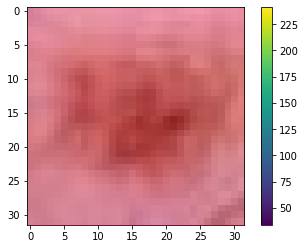

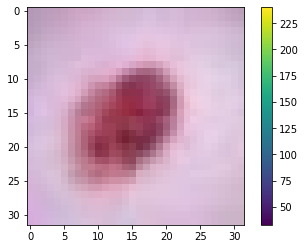

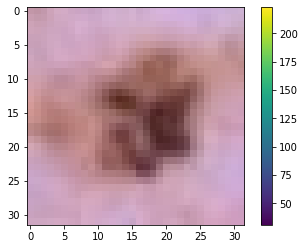

In [ ]:
import matplotlib.pyplot as plt
import cv2

# negative examples
labelex_='{}/0_0.jpg'.format(label_dir)
image = cv2.imread(labelex_)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)

labelex_='{}/105_0.jpg'.format(label_dir)
image = cv2.imread(labelex_)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)

labelex_='{}/100_0.jpg'.format(label_dir)
image = cv2.imread(labelex_)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)

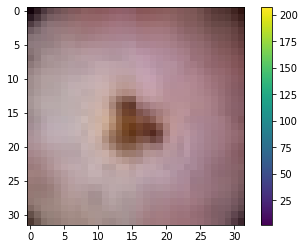

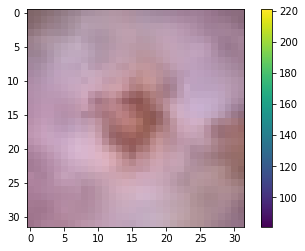

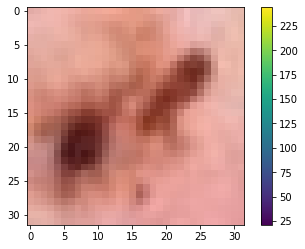

In [ ]:
# positive examples
labelex_='{}/101_1.jpg'.format(label_dir)
image = cv2.imread(labelex_)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)

labelex_='{}/103_1.jpg'.format(label_dir)
image = cv2.imread(labelex_)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)

labelex_='{}/104_1.jpg'.format(label_dir)
image = cv2.imread(labelex_)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)

There are few things 
1. Resolution of photos are poor
2. Legions are seen in both of the cases: both benign and malign
3. There are considerable variations in the color/brightness of background/ legion from photo to photo. 

Augmentation
Invariances that we can expect from utilizing the above data 
1. rotation: flipping the image upside down or at angle should not affect the result
2. Gaussian noise: adding a small noise to the image should not alter the result - although I'm curious how the poor quality in the image would interact with the noise addition (perhaps not much)

3. Cropping: wouldn't work as this could crop out the legions from the image 
4. Translation: wouldn't work if the legion moves out of the image: may work with the reflect or wrap interpolation


1. Dataset class for supervised learning 

In [213]:
import skimage.io
import torch.utils.data as dt
import torch.nn.functional as F
import glob

class LabelDataset(dt.Dataset):

    def __init__(self, dir_path, transform= None ):
      """
      optional transform argument for image pre-processing and augmentation.
      """
      self.dir_path = dir_path
      self.transform = transform
      print(self.dir_path)

    def __len__(self):
      """
      Return the number of images 
      """
      k= len([file for file in glob.glob("{}/*.jpg".format(self.dir_path))])
      return k 

    def __getitem__(self, i): 
      """
      Return the ith image in the set 
      """
      f_n = '{0}/{1}_*.jpg'.format(self.dir_path,i)
      f_n = glob.glob(f_n)
      image = skimage.io.imread(f_n[0])
      label = f_n[0].split('_')[-1].split('.')[0]
      sample = {'image': image, 'label': 'positive' if label =='1' else 'negative'}

      if self.transform:
          sample = self.transform(sample)

      return sample


In [214]:
label_dataset = LabelDataset(dir_path=label_dir)

/content/MelanomaDetection/labeled


In [215]:
len(label_dataset)

200

0 (32, 32, 3)
negative
1 (32, 32, 3)
positive
2 (32, 32, 3)
negative
3 (32, 32, 3)
positive


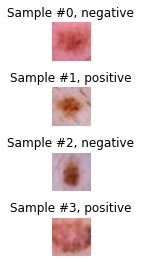

In [99]:
for i in range(4):
    sample = label_dataset[i]
    print(i, sample['image'].shape)
    print(sample['label'])

    ax = plt.subplot(4, 1, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{0}, {1}'.format(i,sample['label']))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

2. Dataset class for unsupervised learning

In [218]:
import skimage.io
import torch.utils.data as dt
import torch.nn.functional as F
import glob
class UnLabelDataset(dt.Dataset):

    def __init__(self, dir_path, transform= None ):
      """
      optional transform argument for image pre-processing and augmentation.
      """
      self.dir_path = dir_path
      self.transform = transform
      print(self.dir_path)

    def __len__(self):
      """
      Return the number of images 
      """
      k= len([file for file in glob.glob("{}/*.jpg".format(self.dir_path))])
      return k 

    def __getitem__(self, i): 
      """
      Return the ith image in the set 
      """
      f_n = '{0}/{1}.jpg'.format(self.dir_path,i)
      f_n = glob.glob(f_n)
      image = skimage.io.imread(f_n[0])
      sample = {'image': image}

      if self.transform:
          sample = self.transform(sample)

      return sample

In [220]:
unlabel_dataset = UnLabelDataset(dir_path=unlabel_dir)

/content/MelanomaDetection/unlabeled


In [221]:
len(unlabel_dataset)

7018

0 (32, 32, 3)
1 (32, 32, 3)
2 (32, 32, 3)
3 (32, 32, 3)


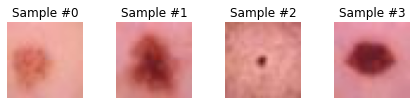

In [100]:
for i in range(4):
    sample = unlabel_dataset[i]
    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [173]:
from torchvision import datasets, models, transforms


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image= sample['image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}


class RandomHorizontalFlip(object):
    """
    Flip the image horizontally
    """

    def __call__(self, sample):
      image = sample['image']
      img = transforms.RandomHorizontalFlip().forward(image)

      return {'image': img}


class RandomVerticalFlip(object):
    """
    Flip the image vertically
    """

    def __call__(self, sample):
      image = sample['image']
      img = transforms.RandomVerticalFlip().forward(image)

      return {'image': img}

trans = transforms.Compose([
                            ToTensor(),
                            RandomHorizontalFlip(),
                            RandomVerticalFlip(),
                            
    ])
                        

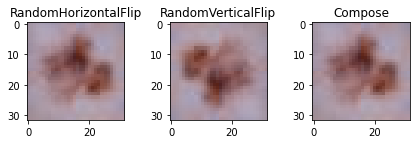

In [185]:
sample = label_dataset[65]
hori = RandomHorizontalFlip()
verti = RandomVerticalFlip()
composed = transforms.Compose([RandomHorizontalFlip(),
                               RandomHorizontalFlip()])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample =ToTensor()(sample)
for i, tsfrm in enumerate([hori, verti, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'].permute(1, 2, 0).numpy())

plt.show()



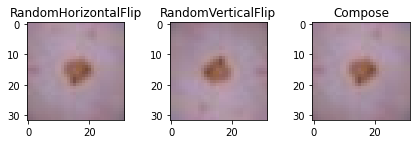

In [188]:
sample = unlabel_dataset[65]
hori = RandomHorizontalFlip()
verti = RandomVerticalFlip()
composed = transforms.Compose([RandomHorizontalFlip(),
                               RandomHorizontalFlip()])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample =ToTensor()(sample)
for i, tsfrm in enumerate([hori, verti, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'].permute(1, 2, 0).numpy())

plt.show()


4. Create Dataloader object and use them to print out one batch out of the data

Batch of the labeled dataset

/content/MelanomaDetection/labeled
0 torch.Size([4, 3, 32, 32])
1 torch.Size([4, 3, 32, 32])
2 torch.Size([4, 3, 32, 32])
3 torch.Size([4, 3, 32, 32])


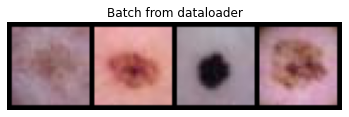

In [224]:
from torch.utils.data import DataLoader



transformed_dataset = LabelDataset(dir_path=label_dir,
                                   transform= transforms.Compose([
                                      ToTensor(),
                                      RandomHorizontalFlip(),
                                      RandomVerticalFlip()]))
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
def show_batch(sample_batched):
    """Show image by batch of samples."""
    images_batch = \
            sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = torchvision.utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

Batch of the unlabeled dataset

/content/MelanomaDetection/unlabeled
0 torch.Size([4, 3, 32, 32])
1 torch.Size([4, 3, 32, 32])
2 torch.Size([4, 3, 32, 32])
3 torch.Size([4, 3, 32, 32])


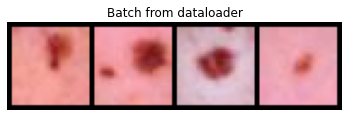

In [226]:
from torch.utils.data import DataLoader



transformed_dataset = UnLabelDataset(dir_path=unlabel_dir,
                                   transform= transforms.Compose([
                                      ToTensor(),
                                      RandomHorizontalFlip(),
                                      RandomVerticalFlip()]))
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
def show_batch(sample_batched):
    """Show image by batch of samples."""
    images_batch = \
            sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = torchvision.utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break